In [2]:
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("drive/MyDrive/toxic_comments/train.csv")

In [ ]:
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.shape

(159571, 8)

In [ ]:
groups = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
data = dict(zip(groups, [0]*len(groups)))
for group in groups:
    data[group] = df[df[group] == 1].shape[0]
data["healthy"] = df.shape[0] - sum(list(data.values()))
healthy = []
for index, row in df.iterrows():
    healthy.append(max(0, 1 - row["toxic"]-row["severe_toxic"]-row["obscene"]-row["threat"]-row["insult"]-row["identity_hate"]))

print(min(healthy))

0


In [23]:
df["label"] = df.iloc[:, 2:8].values.tolist()
df.label = df.label.apply(lambda x: np.array(x).astype('float32'))

In [24]:
df.label

0         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
3         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
4         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
                       ...              
159566    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
159567    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
159568    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
159569    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
159570    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Name: label, Length: 159571, dtype: object

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, activations, models, optimizers, losses, metrics, regularizers
import tensorflow_hub as hub
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

features = df["comment_text"]
labels = df["label"]
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3)

x = df["comment_text"]
token = Tokenizer()
token.fit_on_texts(train_features)
train_seq = token.texts_to_sequences(train_features)
pad_seq_train = pad_sequences(train_seq,maxlen=300)

test_seq = token.texts_to_sequences(test_features)
pad_seq_test = pad_sequences(test_seq, maxlen=300)
vocab_size = len(token.word_index)+1
embedding_vector = {}

f = open('drive/MyDrive/toxic_comments/glove.6B.50d.txt', encoding='utf-8')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

embedding_matrix = np.zeros((vocab_size,50))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400000it [00:06, 57452.34it/s]
100%|██████████| 169228/169228 [00:00<00:00, 644016.42it/s]


In [32]:


class MODEL(tf.keras.Model):
    def __init__(self):
        super().__init__()
        embed_layer = layers.Embedding(vocab_size,50,weights = [embedding_matrix],input_length=300,trainable = False)

        self.glove_head = models.Sequential([
            embed_layer,
            layers.Dropout(0.2),
            layers.BatchNormalization(),
            layers.Conv1D(64, 4, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5)),
            layers.MaxPooling1D(),
            layers.Conv1D(32, 4, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5)),
            layers.MaxPooling1D(),
            layers.Conv1D(16, 4, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5)),
            layers.MaxPooling1D(),
            layers.GRU(100),
            layers.Dense(50, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5)),
            layers.Dense(100, activation="sigmoid")
        ])

        url_model = "https://tfhub.dev/google/nnlm-en-dim128/2"
        embed_layer_2 = hub.KerasLayer(url_model, trainable=True, input_shape=[], dtype=tf.string)

        self.nnlm_head = models.Sequential([
            embed_layer_2,
            layers.Dropout(0.2),
            layers.BatchNormalization(),
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.2),
            layers.BatchNormalization(),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.2),
            layers.BatchNormalization(),
            layers.Dense(100, activation="sigmoid")
        ])

        self.final_head = models.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.2),
            layers.BatchNormalization(),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.2),
            layers.BatchNormalization(),
            layers.Dense(6, activation="sigmoid")
        ])

    def call(self, x):
        seq, text = x
        seq_out = self.glove_head(seq)
        text_out = self.nnlm_head(text)
        cc = tf.concat([seq_out, text_out], axis=1)

        return self.final_head(cc)



In [155]:
embed_layer = layers.Embedding(vocab_size,50,weights = [embedding_matrix],input_length=300,trainable = False)
model_2 = models.Sequential([
    embed_layer,    
    layers.Bidirectional(layers.GRU(100)),
    layers.Dense(6, activation="sigmoid")
])


In [157]:
model_2.compile(optimizers.Adam(learning_rate=5e-4), loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy(name='accuracy'), metrics.AUC()])


epochs_history_simple = model_2.fit(pad_seq_train, train_labels, epochs=3,
                           validation_data=(pad_seq_test, test_labels),
                           verbose=1)

AttributeError: ignored

In [29]:
train_labels = np.asarray(train_labels.to_list()).astype(np.float32)

In [30]:
test_labels = np.asarray(test_labels.to_list()).astype(np.float32)

In [34]:
model = MODEL()
model.compile(optimizers.Adam(learning_rate=5e-4), loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy(name='accuracy')])


epochs_history_simple = model.fit((pad_seq_train, train_features), train_labels, epochs=100,
                           validation_data=((pad_seq_test, test_features), test_labels),
                           verbose=1)

Epoch 1/100
3491/3491 [==============================] - 546s 155ms/step - loss: 0.1762 - accuracy: 0.9360 - val_loss: 0.0776 - val_accuracy: 0.9730
Epoch 2/100
3491/3491 [==============================] - 538s 154ms/step - loss: 0.0804 - accuracy: 0.9704 - val_loss: 0.0733 - val_accuracy: 0.9734
Epoch 3/100
3491/3491 [==============================] - 538s 154ms/step - loss: 0.0734 - accuracy: 0.9726 - val_loss: 0.0781 - val_accuracy: 0.9723
Epoch 4/100
3491/3491 [==============================] - 537s 154ms/step - loss: 0.0691 - accuracy: 0.9742 - val_loss: 0.0842 - val_accuracy: 0.9685
Epoch 5/100
3491/3491 [==============================] - 538s 154ms/step - loss: 0.0640 - accuracy: 0.9767 - val_loss: 0.0908 - val_accuracy: 0.9683
Epoch 6/100
3491/3491 [==============================] - 538s 154ms/step - loss: 0.0610 - accuracy: 0.9776 - val_loss: 0.0845 - val_accuracy: 0.9702
Epoch 7/100
3491/3491 [==============================] - 556s 159ms/step - loss: 0.0592 - accuracy: 0.9782

KeyboardInterrupt: ignored

In [37]:
model.save_weights("big_gains.h5")

In [38]:
model_load = MODEL()

In [43]:
model_load((pad_seq_test[:1], test_features[:1]))
model_load.load_weights("big_gains.h5")

In [48]:
model_load.compile(metrics=[metrics.BinaryAccuracy("binary_acc"), metrics.AUC()])

In [159]:
model_2.evaluate(pad_seq_test, test_labels)

1496/1496 [==============================] - 69s 46ms/step - loss: 0.0475 - accuracy: 0.9821 - auc_3: 0.9832


[0.0475340262055397, 0.9821003675460815, 0.9831740260124207]

In [128]:
df_test_text = pd.read_csv("drive/MyDrive/toxic_comments/test.csv")
df_test_labels = pd.read_csv("drive/MyDrive/toxic_comments/test_labels.csv")

In [129]:
df_test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [130]:
df_test_text[df_test_text.id=="000247e83dcc1211"]

,id,comment_text
7,000247e83dcc1211,:Dear god this site is horrible.


In [131]:
df_test_text.head(6)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...


In [132]:
df_test_labels = df_test_labels[df_test_labels.toxic != -1]

In [133]:
df_test_labels["label"] = df_test_labels.iloc[:, 1:7].values.tolist()
df_test_labels.label = df_test_labels.label.apply(lambda x: np.array(x).astype('float32'))

In [134]:
df_test_text = df_test_text[df_test_text.id.isin(df_test_labels.id.tolist())]

In [117]:
print(df_test_text.comment_text.size)

63978


In [135]:
df_test = pd.DataFrame({"text":df_test_text.comment_text, "label":df_test_labels.label})

In [119]:
df_test.text.size

63978

In [120]:
df_test_labels.label

5         [0.0, 0.0, 0.0, 0.0, 0.0]
7         [0.0, 0.0, 0.0, 0.0, 0.0]
11        [0.0, 0.0, 0.0, 0.0, 0.0]
13        [0.0, 0.0, 0.0, 0.0, 0.0]
14        [0.0, 0.0, 0.0, 0.0, 0.0]
                    ...            
153150    [0.0, 0.0, 0.0, 0.0, 0.0]
153151    [0.0, 0.0, 0.0, 0.0, 0.0]
153154    [0.0, 0.0, 0.0, 0.0, 0.0]
153155    [0.0, 1.0, 0.0, 1.0, 0.0]
153156    [0.0, 0.0, 0.0, 0.0, 0.0]
Name: label, Length: 63978, dtype: object

In [136]:
super_test_features = df_test["text"].astype(str)

In [122]:
print(super_test_features.size, )

63978


In [137]:
df_test_seq = token.texts_to_sequences(super_test_features)
df_test_seq_seq = pad_sequences(df_test_seq,maxlen=300)

In [138]:
super_test_labels = np.asarray(df_test_labels.label.to_list()).astype(np.float32)

In [139]:
model_load.evaluate((df_test_seq_seq, super_test_features), super_test_labels)

2000/2000 [==============================] - 26s 13ms/step - loss: 2.3112e-05 - binary_acc: 0.9703 - auc: 0.9124


[2.311197567905765e-05, 0.9703261852264404, 0.9123623967170715]

In [ ]:
import matplotlib.pyplot as plt

<BarContainer object of 7 artists>

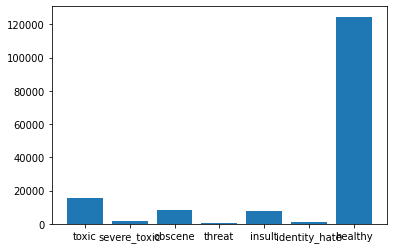

In [ ]:
plt.bar(list(data.keys()), list(data.values()))

In [ ]:
def tts(df, ratio):
    df = df.sample(frac=1).reset_index(drop=True)
   
    trains = df.iloc[:int(ratio*len(df))]
    tests = df.iloc[int(ratio*len(df)):]


        
    return trains, tests
        

In [ ]:
#df, _ = tts(df, 0.1)

In [ ]:
df.shape

(159571, 8)

In [ ]:
pip install transformers

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
train, test = tts(df, 0.8)

In [ ]:
train.shape, test.shape

((127656, 8), (31915, 8))

In [ ]:
class ToxicDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["comment_text"]
        
        text = tokenizer(text,
                               padding='max_length', max_length = 90, truncation=True,
                                return_tensors="pt")
        
        groups = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
        label = torch.tensor([row[g] for g in groups], dtype=torch.float32)
        
        return text, label

In [ ]:
from torch import nn
from transformers import BertModel

class BertFakeNews(nn.Module):

    def __init__(self):

        super().__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(768, 400),
            nn.Dropout(0.2),
            nn.Linear(400, 6),
            nn.Sigmoid()
        )

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)

        return self.fc(pooled_output)

In [ ]:
train_data = ToxicDataset(train)
test_data = ToxicDataset(test)
train_loader = DataLoader(train_data, shuffle=True, batch_size=1)
test_loader = DataLoader(test_data, shuffle=True, batch_size=1)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = BertFakeNews().to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)

In [ ]:
import tqdm
def test_model():
    valid = 0
    running_loss = 0
    for text, labels in tqdm.tqdm(test_loader):
        labels = labels.to(device)
        mask = text['attention_mask'].to(device)
        input_id = text['input_ids'].squeeze(1).to(device)
        
        output = model(input_id, mask)
        loss = criterion(output, labels)
        running_loss += loss.item()
        
        pred = torch.round(output)
        valid += (pred.eq(labels)).sum()
    
    print(f"loss: {running_loss}, accuracy: {valid/len(test_data)/6}")
        

In [ ]:
import gc
for epoch in range(100):
    torch.save(model, f"drive/MyDrive/toxic_comments/model_{epoch}.pth")
    for i, (text, labels) in enumerate(train_loader):
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        labels = labels.to(device)
        mask = text['attention_mask'].to(device)
        input_id = text['input_ids'].squeeze(1).to(device)
        
        output = model(input_id, mask)
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        if(i % 10 == 0):
            print(f"epoch {epoch}, step: {i}/{len(train_data)}, loss: {loss}")

    test_model()

Streaming output truncated to the last 5000 lines.
epoch 0, step: 77660/127656, loss: 0.008935777470469475
epoch 0, step: 77670/127656, loss: 0.011893446557223797
epoch 0, step: 77680/127656, loss: 0.010815953835844994
epoch 0, step: 77690/127656, loss: 0.01226853858679533
epoch 0, step: 77700/127656, loss: 0.12021078169345856
epoch 0, step: 77710/127656, loss: 0.012108748778700829
epoch 0, step: 77720/127656, loss: 0.013231161050498486
epoch 0, step: 77730/127656, loss: 0.011196605861186981
epoch 0, step: 77740/127656, loss: 0.006551904603838921
epoch 0, step: 77750/127656, loss: 0.010317899286746979
epoch 0, step: 77760/127656, loss: 0.015065275132656097
epoch 0, step: 77770/127656, loss: 0.01031577866524458
epoch 0, step: 77780/127656, loss: 0.011830447241663933
epoch 0, step: 77790/127656, loss: 0.013245361857116222
epoch 0, step: 77800/127656, loss: 0.013129651546478271
epoch 0, step: 77810/127656, loss: 0.008599158376455307
epoch 0, step: 77820/127656, loss: 0.009865225292742252


100%|██████████| 31915/31915 [07:28<00:00, 71.11it/s]


loss: 1185.1531435800716, accuracy: 0.9632774591445923
epoch 1, step: 0/127656, loss: 0.012906039133667946
epoch 1, step: 10/127656, loss: 0.006058826111257076
epoch 1, step: 20/127656, loss: 0.009030120447278023
epoch 1, step: 30/127656, loss: 0.004060372244566679
epoch 1, step: 40/127656, loss: 0.00726316636428237
epoch 1, step: 50/127656, loss: 0.0045259008184075356
epoch 1, step: 60/127656, loss: 0.006032948382198811
epoch 1, step: 70/127656, loss: 0.005029780324548483
epoch 1, step: 80/127656, loss: 0.009778342209756374
epoch 1, step: 90/127656, loss: 0.007706912234425545
epoch 1, step: 100/127656, loss: 0.004693928640335798
epoch 1, step: 110/127656, loss: 0.004794818814843893
epoch 1, step: 120/127656, loss: 0.0051606185734272
epoch 1, step: 130/127656, loss: 0.004712600260972977
epoch 1, step: 140/127656, loss: 0.006563751958310604
epoch 1, step: 150/127656, loss: 0.009322567842900753
epoch 1, step: 160/127656, loss: 0.004660601262003183
epoch 1, step: 170/127656, loss: 0.00755

KeyboardInterrupt: ignored

In [ ]:
test_model()

  0%|          | 113/31915 [00:03<14:07, 37.53it/s]


KeyboardInterrupt: ignored